# Getting Started - RocketPy in Colab


We start by setting up our environment. To run this notebook, we will need:

- RocketPy
- Data files (we will clone RocketPy's repository for these)

Therefore, let's run the following lines of code:

In [ ]:
!pip install rocketpy
!git clone https://github.com/giovaniceotto/RocketPy.git

In [ ]:
import os

os.chdir("RocketPy/docs/notebooks")

Now we can start!

Here we go through a simplified rocket trajectory simulation to get you started. Let's start by importing the rocketpy module.


In [1]:
from rocketpy import Environment, SolidMotor, Rocket, Flight

It is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.


In [2]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

## Setting Up a Simulation


### Creating an Environment for Spaceport America



The `Environment` class is used to define the atmosphere, the winds, and the gravity models.

You can find more information about the `Environment` class in the [Environment Class Usage Docs](https://docs.rocketpy.org/en/latest/notebooks/environment/environment_class_usage.html).

In [3]:
env = Environment(latitude=32.990254, longitude=-106.974998, elevation=1400)

To get weather data from the GFS forecast, available online, we run the following lines.

First, we set tomorrow's date.


In [4]:
import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.set_date(
    (tomorrow.year, tomorrow.month, tomorrow.day, 12)
)  # Hour given in UTC time

Then, we tell env to use a GFS forecast to get the atmospheric conditions for flight.

Don't mind the warning, it just means that not all variables, such as wind speed or atmospheric temperature, are available at all altitudes given by the forecast.


In [5]:
env.set_atmospheric_model(type="Forecast", file="GFS")

We can see what the weather will look like by calling the info method!



Gravity Details

Acceleration of Gravity at Lauch Site: 9.79111266229703 m/s²


Launch Site Details

Launch Date: 2023-08-11 12:00:00 UTC
Launch Site Latitude: 32.99025°
Launch Site Longitude: -106.97500°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315468.64 W    3651938.65 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1471.5 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 79.504 km
Forecast Time Period: From  2023-08-10 18:00:00  to  2023-08-26 18:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 3.88 m/s
Surface Wind Direction: 160.03°
Surface Wind Heading: 340.03°
Surface Pressure: 854.13 hPa
Surface Temperature: 296.19 K
Surface Air Density: 1.005 kg/m³
Surface Speed of Sound: 345.01 m/s


Atmospheric Model Plots



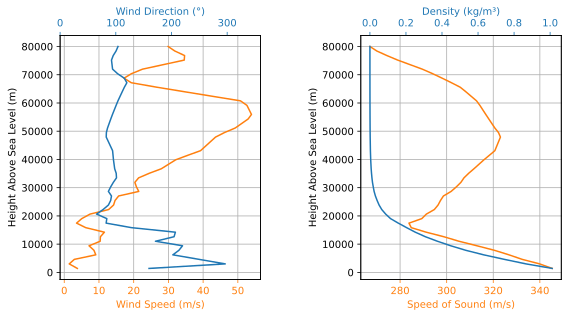

In [6]:
env.info()

### Creating a Motor

A solid rocket motor is used in this case. To create a motor, the SolidMotor class is used and the required arguments are given.

The SolidMotor class requires the user to have a thrust curve ready. This can come either from a .eng file for a commercial motor, such as below, or a .csv file from a static test measurement.

Besides the thrust curve, other parameters such as grain properties and nozzle dimensions must also be given.

See [Solid Motor Class Usage Docs](https://docs.rocketpy.org/en/latest/user/motors/solidmotor.html) for more information.


In [7]:
Pro75M1670 = SolidMotor(
    thrust_source="../../data/motors/Cesaroni_M1670.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

**Pay special attention to *position* related parameters:**
More details on [Positions and Coordinate Systems](https://docs.rocketpy.org/en/latest/user/positions.html)


To see what our thrust curve looks like, along with other import properties, we invoke the info method yet again. You may try the all_info method if you want more information all at once!


Nozzle Details
Nozzle Radius: 0.033 m
Nozzle Throat Radius: 0.011 m

Grain Details
Number of Grains: 5
Grain Spacing: 0.005 m
Grain Density: 1815 kg/m3
Grain Outer Radius: 0.033 m
Grain Inner Radius: 0.015 m
Grain Height: 0.12 m
Grain Volume: 0.000 m3
Grain Mass: 0.591 kg

Motor Details
Total Burning Time: 3.9 s
Total Propellant Mass: 2.956 kg
Average Propellant Exhaust Velocity: 2038.745 m/s
Average Thrust: 1545.218 N
Maximum Thrust: 2200.0 N at 0.15 s after ignition.
Total Impulse: 6026.350 Ns



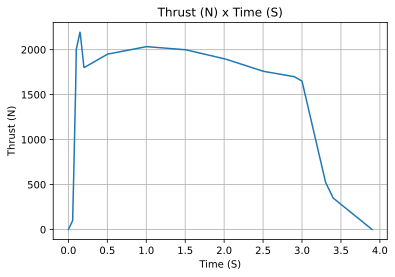

In [8]:
Pro75M1670.info()

### Creating a Rocket


A rocket is composed of several components. Namely, we must have a motor (good thing we have the Pro75M1670 ready), a couple of aerodynamic surfaces (nose cone, fins and tail) and parachutes (if we are not launching a missile).

You can find more information about the `Rocket` class in the [Rocket Class Usage Docs](https://docs.rocketpy.org/en/latest/user/rocket.html).

Let's start by initializing our rocket, named Calisto, entering inertia properties, some dimensions and drag curves.

**Pay special attention to *position* related parameters:**
More details on [Positions and Coordinate Systems](https://docs.rocketpy.org/en/latest/user/positions.html)



In [9]:
calisto = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="../../data/calisto/powerOffDragCurve.csv",
    power_on_drag="../../data/calisto/powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

rail_buttons = calisto.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.618,
    angular_position=45,
)

To add the motor to our rocket we need only inform what motor we are adding (Pro75M1670) and inform the position, in meters, of the motor's nozzle exit area relative to the previously defined coordinate system.


In [10]:
calisto.add_motor(Pro75M1670, position=-1.255)

#### Adding Aerodynamic Surfaces


Now we define the aerodynamic surfaces. They are really straight forward with special attention needed only for the position values. Here is a quick guide:

- The positions given **must** be relative to the same coordinate system as the rockets;
- Position of the Nosecone refers to the tip of the nose;
- Position of fins refers to the point belonging to the root chord which is highest in the rocket coordinate system;
- Position of the tail the point belonging to the tail which is highest in the rocket coordinate system.

See more details in [Positions and Coordinate Systems](https://docs.rocketpy.org/en/latest/user/positions.html)

In [11]:
nose_cone = calisto.add_nose(
    length=0.55829, kind="vonKarman", position=1.278
)

fin_set = calisto.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("../../data/calisto/NACA0012-radians.csv","radians"),
)

tail = calisto.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)

To see all information regarding the rocket we just defined we run:



Inertia Details

Rocket Mass: 14.426 kg
Rocket Dry Mass: 16.241 kg (With Motor)
Rocket Mass: 19.197 kg (With Propellant)
Rocket Inertia (with motor, but without propellant) 11: 7.864 kg*m2
Rocket Inertia (with motor, but without propellant) 22: 7.864 kg*m2
Rocket Inertia (with motor, but without propellant) 33: 0.036 kg*m2
Rocket Inertia (with motor, but without propellant) 12: 0.000 kg*m2
Rocket Inertia (with motor, but without propellant) 13: 0.000 kg*m2
Rocket Inertia (with motor, but without propellant) 23: 0.000 kg*m2


Geometrical Parameters

Rocket Maximum Radius: 0.0635 m
Rocket Frontal Area: 0.012668 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass withour Motor: 0.105 m
Rocket Center of Dry Mass - Nozzle Exit Distance: 1.150 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.753 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.116 m


Aerodynamics Lift Coefficient Derivatives

Nosecone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficie

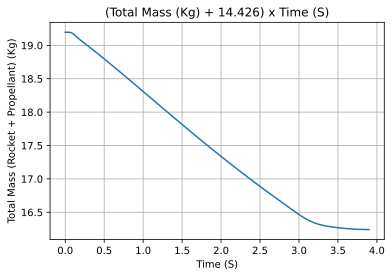

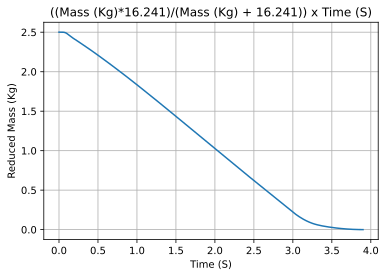


Aerodynamics Plots


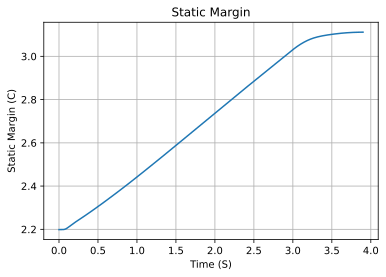

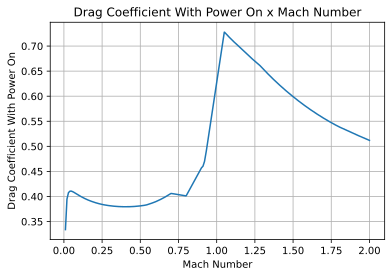

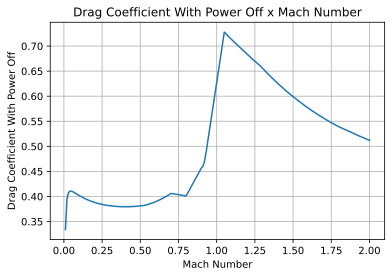

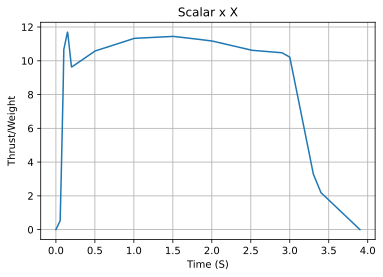

In [12]:
calisto.all_info()

#### Adding Parachutes


Finally, we have parachutes! Calisto will have two parachutes, Drogue and Main. The Drogue parachute will open at apogee while the Main parachute will open at 800m above ground level

For more details see [Adding Parachutes](https://docs.rocketpy.org/en/latest/user/rocket.html#adding-parachutes)

In [13]:
Main = calisto.add_parachute(
    "Main",
    cd_s=10.0,
    trigger=800,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = calisto.add_parachute(
    "Drogue",
    cd_s=1.0,
    trigger="apogee",
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Just be careful if you run this last cell multiple times! If you do so, your rocket will end up with lots of parachutes which activate together, which may cause problems during the flight simulation. We advise you to re-run all cells which define our rocket before running this, preventing unwanted old parachutes. Alternatively, you can run the following lines to remove parachutes.

```python
Calisto.parachutes.remove(Drogue)
Calisto.parachutes.remove(Main)
```


## Simulating a Flight

Simulating a flight trajectory is as simple as initializing a Flight class object givin the rocket and environnement set up above as inputs. The launch rail inclination and heading are also given here.


In [14]:
test_flight = Flight(
    rocket=calisto, environment=env, rail_length=5.2, inclination=85, heading=0
)

## Analyzing the Results

RocketPy gives you many plots, thats for sure! They are divided into sections to keep them organized. Alternatively, see the Flight class documentation to see how to get plots for specific variables only, instead of all of them at once.



Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 1471.47 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Surface Wind Conditions

Frontal Surface Wind Speed: 3.65 m/s
Lateral Surface Wind Speed: 1.32 m/s


Launch Rail

Launch Rail Length: 5.2  m
Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 0.372 s
Rail Departure Velocity: 26.567 m/s
Rail Departure Static Margin: 2.273 c
Rail Departure Angle of Attack: 8.397°
Rail Departure Thrust-Weight Ratio: 10.165
Rail Departure Reynolds Number: 1.851e+05


Burn out State

Burn out time: 3.900 s
Altitude at burn out: 660.807 m (AGL)
Rocket velocity at burn out: 281.091 m/s
Freestream velocity at burn out: 281.084 m/s
Mach Number at burn out: 0.819
Kinetic energy at burn out: 6

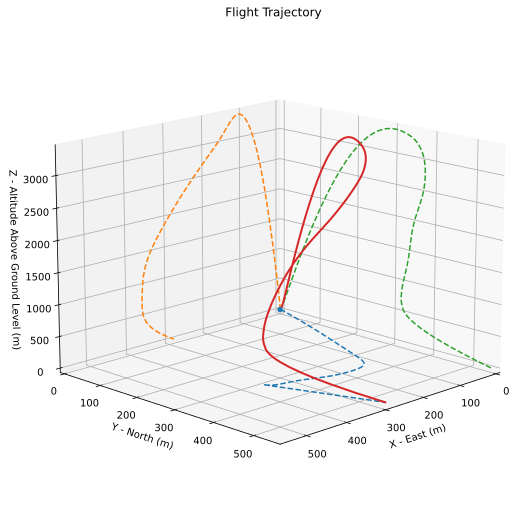



Trajectory Kinematic Plots



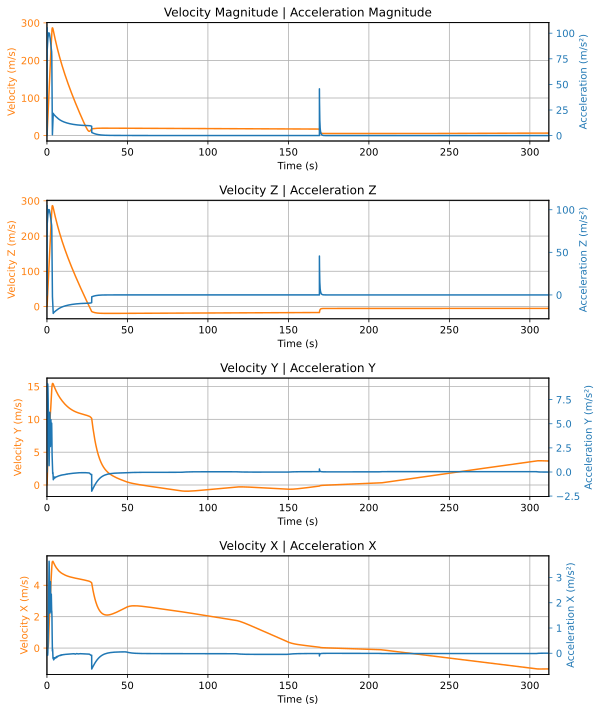



Angular Position Plots



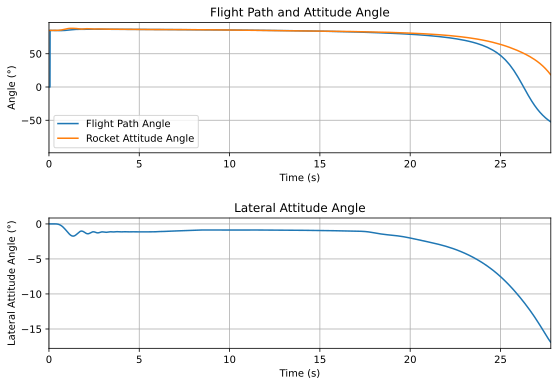



Path, Attitude and Lateral Attitude Angle plots



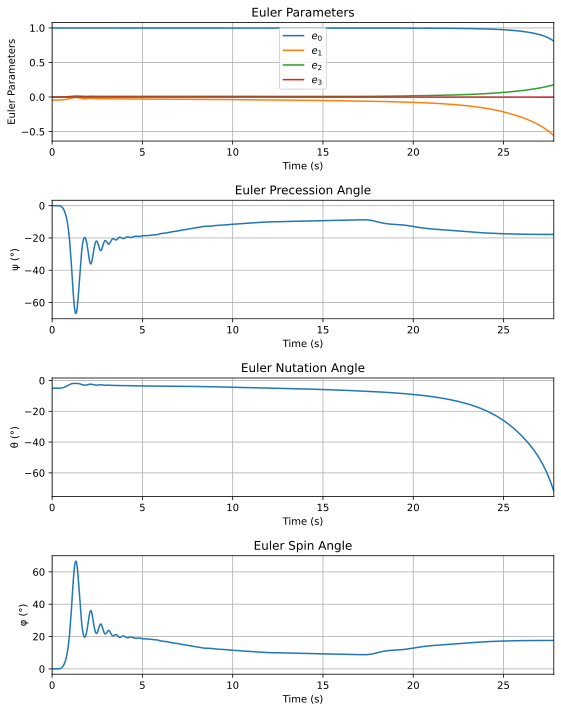



Trajectory Angular Velocity and Acceleration Plots



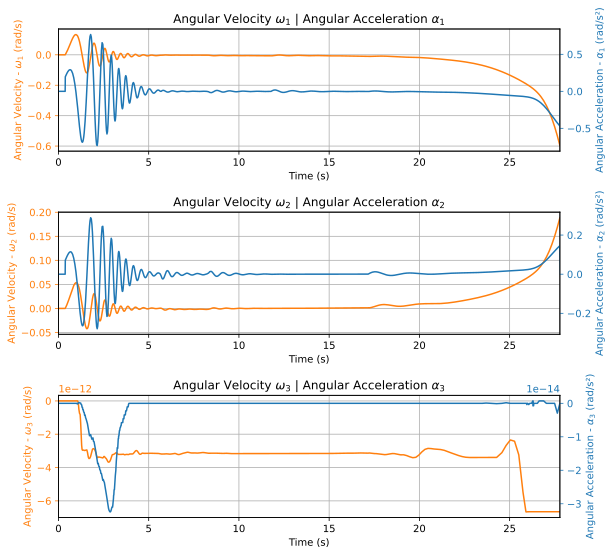



Aerodynamic Forces Plots



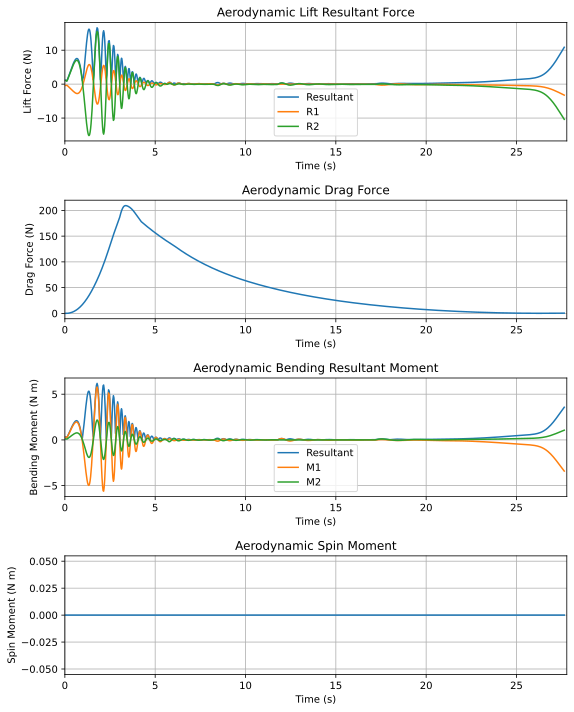



Rail Buttons Forces Plots



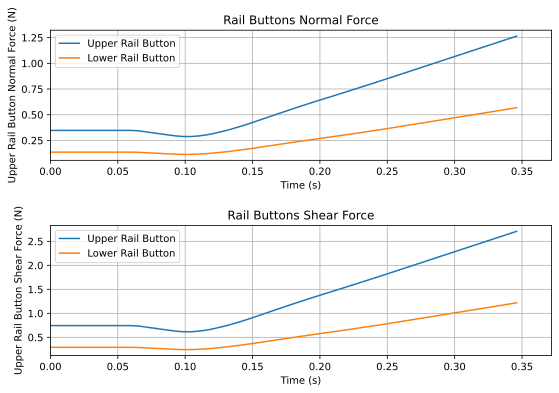



Trajectory Energy Plots



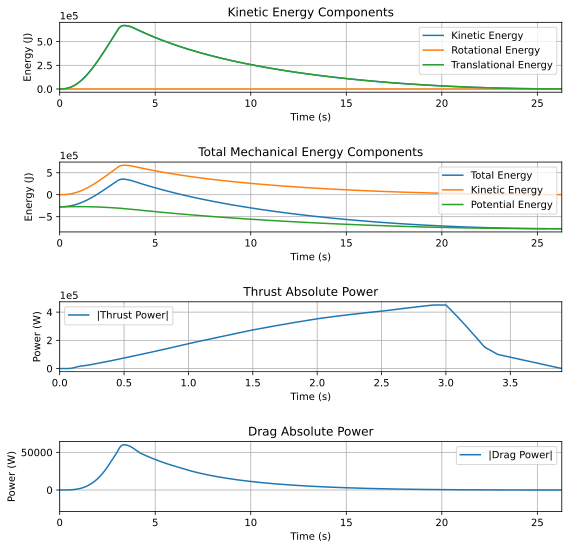



Trajectory Fluid Mechanics Plots



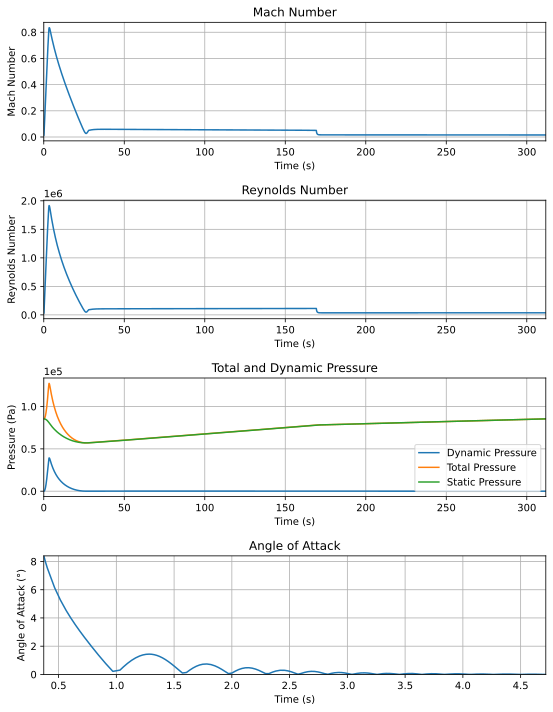



Trajectory Stability and Control Plots



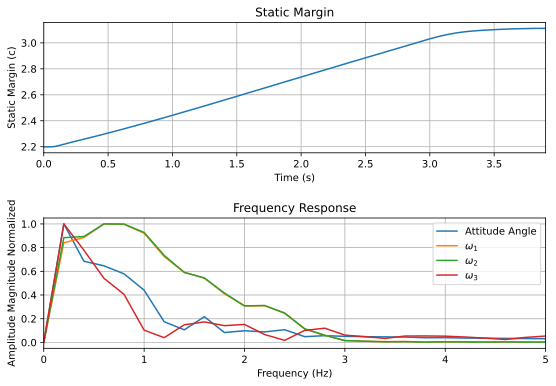



Rocket and Parachute Pressure Plots



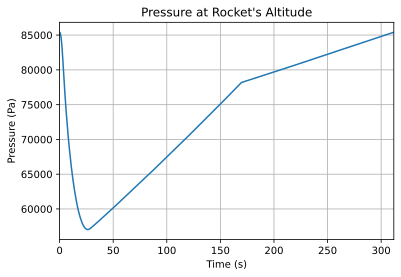


Parachute:  Main


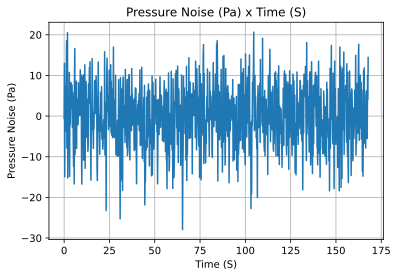

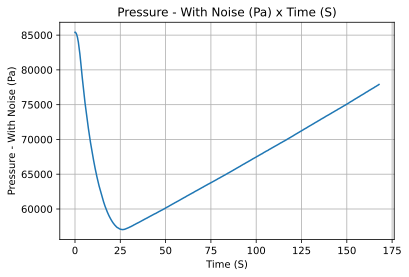

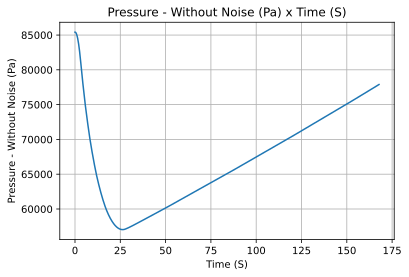


Parachute:  Drogue


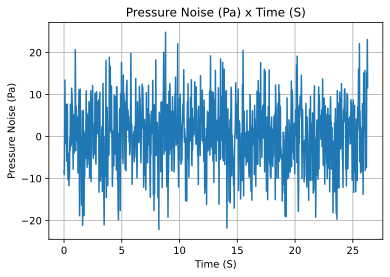

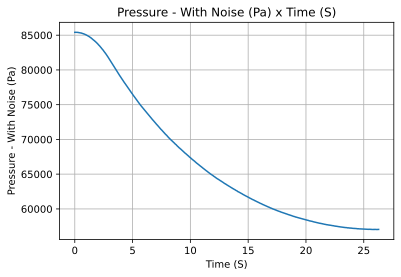

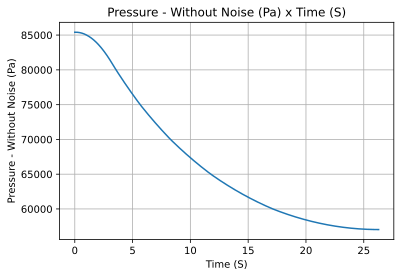

In [15]:
test_flight.all_info()

Export Flight Trajectory to a .kml file so it can be opened on Google Earth


In [16]:
test_flight.export_kml(
    file_name="trajectory.kml",
    extrude=True,
    altitude_mode="relative_to_ground",
)

File  trajectory.kml  saved with success!


## Using Simulation for Design

Here, we go through a couple of examples which make use of RocketPy in cool ways to help us design our rocket.


### Apogee as a Function of Mass

This one is a classic one! We always need to know how much our rocket's apogee will change when our payload gets heavier.


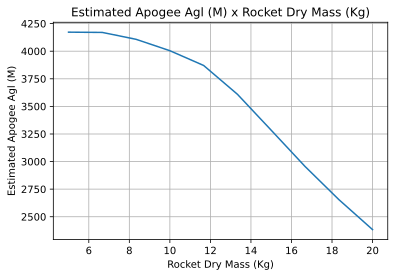

'Function from R1 to R1 : (Rocket Dry Mass (kg)) → (Estimated Apogee AGL (m))'

In [17]:
from rocketpy.utilities import apogee_by_mass

apogee_by_mass(flight=test_flight, min_mass=5, max_mass=20, points=10, plot=True)

### Out of Rail Speed as a Function of Mass

Lets make a really important plot. Out of rail speed is the speed our rocket has when it is leaving the launch rail. This is crucial to make sure it can fly safely after leaving the rail. A common rule of thumb is that our rocket's out of rail speed should be 4 times the wind speed so that it does not stall and become unstable.


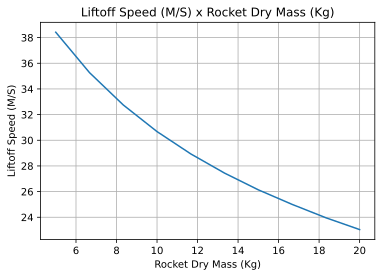

'Function from R1 to R1 : (Rocket Dry Mass (kg)) → (Liftoff Speed (m/s))'

In [18]:
from rocketpy.utilities import liftoff_speed_by_mass

liftoff_speed_by_mass(flight=test_flight, min_mass=5, max_mass=20, points=10, plot=True)

### Dynamic Stability Analysis

Ever wondered how static stability translates into dynamic stability? Different static margins result in different dynamic behavior, which also depends on the rocket's rotational inertial.

Let's make use of RocketPy's helper class called Function to explore how the dynamic stability of Calisto varies if we change the fins span by a certain factor.


Simulating Rocket with Static Margin of 0.113->0.846 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 1.064->1.796 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 2.014->2.747 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 2.964->3.697 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 3.914->4.647 c
Simulation Completed at Time: 5.0000 s


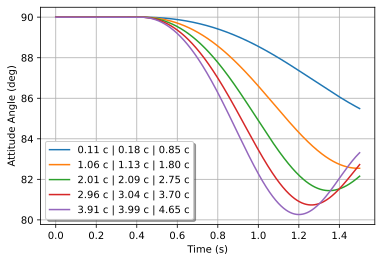

In [19]:
# Helper class
from rocketpy import Function
import copy

# Prepare a copy of the rocket
calisto2 = copy.deepcopy(calisto)

# Prepare Environment Class
custom_env = Environment()
custom_env.set_atmospheric_model(type="custom_atmosphere", wind_v=-5)

# Simulate Different Static Margins by Varying Fin Position
simulation_results = []

for factor in [-0.5, -0.2, 0.1, 0.4, 0.7]:
    # Modify rocket fin set by removing previous one and adding new one
    calisto2.aerodynamic_surfaces.pop(-1)

    fin_set = calisto2.add_trapezoidal_fins(
        n=4,
        root_chord=0.120,
        tip_chord=0.040,
        span=0.100,
        position=-1.04956 * factor,
    )
    # Simulate
    print(
        "Simulating Rocket with Static Margin of {:1.3f}->{:1.3f} c".format(
            calisto2.static_margin(0),
            calisto2.static_margin(calisto2.motor.burn_out_time),
        )
    )
    test_flight = Flight(
        rocket=calisto2,
        environment=custom_env,
        rail_length=5.2,
        inclination=90,
        heading=0,
        max_time_step=0.01,
        max_time=5,
        terminate_on_apogee=True,
        verbose=True,
    )
    # Store Results
    static_margin_at_ignition = calisto2.static_margin(0)
    static_margin_at_out_of_rail = calisto2.static_margin(test_flight.out_of_rail_time)
    static_margin_at_steady_state = calisto2.static_margin(test_flight.t_final)
    simulation_results += [
        (
            test_flight.attitude_angle,
            "{:1.2f} c | {:1.2f} c | {:1.2f} c".format(
                static_margin_at_ignition,
                static_margin_at_out_of_rail,
                static_margin_at_steady_state,
            ),
        )
    ]

Function.compare_plots(
    simulation_results,
    lower=0,
    upper=1.5,
    xlabel="Time (s)",
    ylabel="Attitude Angle (deg)",
)

### Characteristic Frequency Calculation

Here we analyse the characteristic frequency of oscillation of our rocket just as it leaves the launch rail. Note that when we ran test_flight.all_info(), one of the plots already showed us the frequency spectrum of our flight. Here, however, we have more control of what we are plotting.


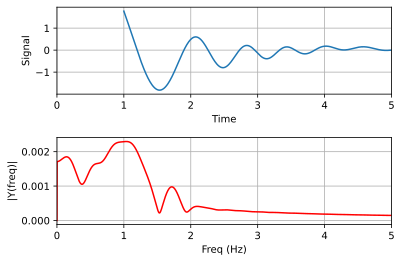

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate first 5 seconds of Flight
flight = Flight(
    rocket=calisto,
    environment=env,
    rail_length=5.2,
    inclination=90,
    heading=0,
    max_time_step=0.01,
    max_time=5,
)

# Perform a Fourier Analysis
Fs = 100.0
# sampling rate
Ts = 1.0 / Fs
# sampling interval
t = np.arange(1, 400, Ts)  # time vector
ff = 5
# frequency of the signal
y = flight.attitude_angle(t) - np.mean(flight.attitude_angle(t))
n = len(y)  # length of the signal
k = np.arange(n)
T = n / Fs
frq = k / T  # two sides frequency range
frq = frq[range(n // 2)]  # one side frequency range
Y = np.fft.fft(y) / n  # fft computing and normalization
Y = Y[range(n // 2)]

# Create the plot
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, y)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Signal")
ax[0].set_xlim((0, 5))
ax[0].grid()
ax[1].plot(frq, abs(Y), "r")  # plotting the spectrum
ax[1].set_xlabel("Freq (Hz)")
ax[1].set_ylabel("|Y(freq)|")
ax[1].set_xlim((0, 5))
ax[1].grid()
plt.subplots_adjust(hspace=0.5)
plt.show()